# Harry Potter story generator using transformers based model.
    In this project, we will create the transformers based model for story generation.

In [1]:
# Import necessary libraries
import torch
from torch import nn
import torch.nn.functional as F
import torchdata
import torchtext

from tqdm import tqdm
import random, math, time
from torch.autograd import Variable

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
# SEED = 555
# torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

cuda:0


## Data Preparation

In [2]:
# I used the data from https://github.com/ErikaJacobs/Harry-Potter-Text-Mining
import os 
path = './data' # assign directory
hp_files = [os.path.join(path, filename) for filename in os.listdir(path)]
len(hp_files) #7 files, each file indicate each book.

7

In [3]:
# Load the data into dataframes
import pandas as pd
# Modified from the code provided by 
Book_list = list()

df = pd.read_csv(hp_files[0], sep="@")
df.head()

flag_token = 0
for book in hp_files:
    if flag_token == 0:
        df = pd.read_csv(book, sep="@")
        flag_token = 1
    else:
        df2 = pd.read_csv(book, sep="@")
        df = pd.concat([df, df2])

print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 36
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     200 non-null    object
 1   Chapter  200 non-null    int64 
 2   Book     200 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 6.2+ KB
None
                                                Text  Chapter  Book
0  THE BOY WHO LIVED  Mr. and Mrs. Dursley, of nu...        1     1
1  THE VANISHING GLASS  Nearly ten years had pass...        2     1
2  THE LETTERS FROM NO ONE  The escape of the Bra...        3     1
3  THE KEEPER OF THE KEYS  BOOM. They knocked aga...        4     1
4  DIAGON ALLEY  Harry woke early the next mornin...        5     1


In [4]:
# Clean dataset a bit.

from spacy.lang.en.stop_words import STOP_WORDS
import spacy
import re

nlp = spacy.load('en_core_web_md')

def preprocessing(sentence):
    
    # Clear the html tag by using regular expression.
    sentence = re.sub("<[^>]*>", "", sentence) # Filter html tag
    sentence = re.sub("[^\x00-\x7F]+", "", sentence) # Filter non-English
    sentence = re.sub("/[^a-zA-Z0-9 ]/", "", sentence) # Filter out some symbol
    #It matches any character which is not contained in the ASCII character set (0-127, i.e. 0x0 to 0x7F)
    doc = nlp(sentence)
    cleaned_tokens = []
    
    # This time "I WILL NOT FILTERS OUT STOPWORD" during the preprocessing as I think it is
    # necessary for story. For the punctuation I think it should be fine to filter out.
    for token in doc:
        if token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM' and token.pos_!= 'X':
                cleaned_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(cleaned_tokens)

#let's apply to the whole dataframe
for i, row in df.iterrows():
    clean_text = preprocessing(row.Text)
    df.at[i, 'Clean_text'] = clean_text

2023-03-12 15:26:12.802269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-12 15:26:13.951622: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-12 15:26:13.951824: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-12 15:26:13.951836: W tensorfl

In [5]:
# Train test split
from sklearn.model_selection import train_test_split

# Split dataset into train and test set
train_set, test_set = train_test_split(df['Clean_text'], test_size=0.3, random_state=999)

# Split train_set into train_set and validation_set 
train_set, val_set  = train_test_split(train_set, test_size=0.2, random_state=999)

# Convert pandas series to list
train_set = train_set.astype(str).values.tolist()
test_set = test_set.astype(str).values.tolist()
val_set = val_set.astype(str).values.tolist()

print(len(train_set), len(test_set), len(val_set))
print(type(train_set), type(test_set), type(val_set))

112 60 28
<class 'list'> <class 'list'> <class 'list'>


In [6]:
# Create tokenizer for each dataset

from torchtext.data.utils import get_tokenizer
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

tokenizer = get_tokenizer('spacy', language='en_core_web_md')

tokenized_dataset_train = yield_tokens(train_set)
tokenized_dataset_val = yield_tokens(val_set)
tokenized_dataset_test = yield_tokens(test_set)

In [7]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [8]:
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(preprocessing(text))

vocab_transform = build_vocab_from_iterator(yield_tokens(train_set), 
                                  min_freq=5,
                                  specials=special_symbols,
                                  special_first=True)
        
vocab_transform.set_default_index(UNK_IDX)   
print('Vocab Size',len(vocab_transform))                         
print(vocab_transform.get_itos()[:10])

Vocab Size 6644
['<unk>', '<pad>', '<sos>', '<eos>', 'the', 'be', 'and', 'he', 'to', 'of']


In [9]:
def get_data(dataset, vocab, batch_size):
    data = []                                                   
    for example in dataset:       
        #appends eos so we know it ends....so model learn how to end...                             
        #tokens = example.append('<eos>') #end of sentence
        example.append('<eos>')
        #numericalize          
        tokens = [vocab[token] for token in example] 
        data.extend(tokens)                                    
    data = torch.LongTensor(data)                                 
    num_batches = data.shape[0] // batch_size 
    data = data[:num_batches * batch_size]                       
    data = data.view(batch_size, num_batches)        
    return data

In [10]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pad_sequence

pad_idx = vocab_transform['<pad>'] #++<----making sure our embedding layer ignores pad

text_pipeline = lambda x: vocab_transform(tokenizer(x))

def collate_batch(batch):
    label_list, text_list = [], []
    for _text in batch:
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    #criterion expects float labels
    return pad_sequence(text_list, padding_value=pad_idx, batch_first=True)

In [11]:
batch_size = 4

train_loader = DataLoader(train_set, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val_set, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test_set, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

In [12]:
# import pickle

# file = open('/root/projects/NLP/Assignment/Transformer_Generator/obj/train_loader.pkl', 'wb')
# pickle.dump(train_loader, file)

# file = open('/root/projects/NLP/Assignment/Transformer_Generator/obj/valid_loader.pkl', 'wb')
# pickle.dump(valid_loader, file)

# file = open('/root/projects/NLP/Assignment/Transformer_Generator/obj/test_loader.pkl', 'wb')
# pickle.dump(test_loader, file)

# file = open('/root/projects/NLP/Assignment/Transformer_Generator/obj/vocab_transform.pkl', 'wb')
# pickle.dump(vocab_transform, file)



## Model

In [13]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads #make sure it's divisible....

        self.fc_q = nn.Linear(hid_dim,hid_dim) 
        self.fc_k = nn.Linear(hid_dim,hid_dim) 
        self.fc_v = nn.Linear(hid_dim,hid_dim) 

        self.fc = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, q, k, v, mask = None):
        batch_size = q.shape[0]
        
        Q = self.fc_q(q)
        K = self.fc_k(k)
        V = self.fc_v(v)
        
        #Q, K, V = [b, l, h]
        #reshape them into head_dim
        #reshape them to [b, n_headm, l, head_dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        #Q, K, V = [b, m_head, l, head_dim]

        #e = QK/sqrt(dk)
        e =  torch.matmul(Q, K.permute(0,1,3,2)) / self.scale
        #e = [b, n_heads, ql, kl]
        
        # torch.Size([64, 8, 50, 50])
        # torch.Size([64, 1, 1, 50, 256])

        if mask is not None:
            e = e.masked_fill(mask == 0, -1e10)

        a = torch.softmax(e, dim=-1)
        #a = [batch size, n_heads, ql, kl]
                    
        #eV
        x = torch.matmul(self.dropout(a),V)
        #x : [b, n_heads, ql, head_di]

        x = x.permute(0, 2, 1, 3).contiguous()
        #x: [b, ql, n_heads, head_dim]

        #concat them together
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [b, ql, h]

        x = self.fc(x)
        #x = [b, ql, h]

        return x, a

### Position-wise Feedforward Layer

In [14]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x = [batch size, seq len, hid dim]

        x = self.dropout(torch.relu(self.fc_1(x)))
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder Layer

<img src = "./figures/GPT-1.png" width=400>

In [15]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()

        self.norm_ff = nn.LayerNorm(hid_dim) #second yellow box
        self.norm_maskedatt = nn.LayerNorm(hid_dim) #first red box
        
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.ff = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, trg_mask):
        #trg      : [b, l, h]
        #enc_src  : [b, sl, h]
        #trg_mask : [b, 1, tl, tl]
        #src_mask : [b, 1, 1, sl]

        #1st box : mask multi, add & norm
        _trg, attention = self.self_attention(trg, trg, trg, trg_mask) #Q, K, V
        _trg    = self.dropout(_trg)
        _trg    = trg + _trg
        trg     = self.norm_maskedatt(_trg)

        #2rd box : ff, add & norm
        _trg    = self.ff(trg)
        _trg    = self.dropout(_trg)
        _trg    = trg + _trg
        trg     = self.norm_ff(_trg)

        return trg, attention

### Decoder

In [16]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads,
                 pf_dim, dropout, device, src_pad_idx,trg_pad_idx, max_length = 100):
        super().__init__()
        self.pos_emb = nn.Embedding(max_length, hid_dim)
        self.trg_emb = nn.Embedding(output_dim, hid_dim)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList(
                            [
                            DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                            for _ in range(n_layers)
                            ]
                            )
        self.fc = nn.Linear(hid_dim, output_dim)
        self.device = device
        
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx

    def make_src_mask(self, src):
        #src = [batch size, src len]
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]
        return src_mask
    
    def make_trg_mask(self, trg):
        trg_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_mask : [batch size, 1, 1, trg len]
        
        trg_len = trg_mask.shape[-1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device =self.device)).bool() #lower triangle
        #trg_sub_mask = [trg len, trg len]
        trg_mask = trg_mask & trg_sub_mask 
        #trg_mask : [batch size, 1, trg len, trg len]
        return trg_mask     
    
    def forward(self, x):
        #src : = [batch size, trg len]
        #enc_src : hidden state from encoder = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = x.shape[0]
        trg_len = x.shape[1]
        
        src_mask = self.make_trg_mask(x)

        #pos
        pos = torch.arange(0,trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos = [batch size, trg len]

        pos_emb = self.pos_emb(pos) #[batch size, trg len, hid dim]
        trg_emb = self.trg_emb(x) #[batch size, trg len, hid dim]

        x = pos_emb + trg_emb * self.scale #[batch size, trg len, hid dim]
        x = self.dropout(x)
        
        for layer in self.layers: #output, hidden
            trg, attention = layer(x, src_mask)
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        output = self.fc(trg)
        #output = [batch size, trg len, output dim]

        return output, attention

In [17]:
class inference():
    def __init__(self,decoder):
        self.decoder = decoder

    #use during inference
    #encapsulates beam_decode or greedy_decode
    def decode(self, src, src_len, trg, hidden, method='beam-search'):
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #src len = [batch size]

        # encoder_outputs, hidden = self.encoder(src, src_len) 
        #encoder_outputs = [src len, batch size, hid dim * 2]  (*2 because of bidirectional)(every hidden states)
        #hidden = [batch size, hid dim]  #final hidden state
       
        hidden = hidden.unsqueeze(0)
        #hidden = [1, batch size, hid dim]
        
        if method == 'beam-search':
            return self.beam_decode(src, trg, hidden)
        else:
            return self.greedy_decode(trg, hidden)

    def greedy_decode(self, trg, decoder_hidden, encoder_outputs=None):
        #trg = [batch size, src len]
        #decoder_hiddens = [1, batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]

        seq_len, batch_size = trg.size()
        decoded_batch = torch.zeros((batch_size, seq_len))
        # decoder_input = torch.LongTensor([[EN.vocab.stoi['<sos>']] for _ in range(batch_size)]).cuda()
        decoder_input = trg[0, :] # sos
        # print(decoder_input.shape)

        # mask = self.create_mask(trg[:, idx].unsqueeze(1))

        for t in range(seq_len): 
            prediction, decoder_hidden = self.decoder(decoder_input)
            topv, topi = prediction.data.topk(1)  # [32, 10004] get candidates
            topi = topi.view(-1)
            decoded_batch[:, t] = topi

            decoder_input = topi.detach().view(-1)

        return decoded_batch #(batch size, length)

    def beam_decode(self, src_tensor, target_tensor, decoder_hiddens, encoder_outputs=None):
        #src_tensor      = [src len, beam_decodebatch size]
        #target_tensor   = [trg len, batch size]
        #decoder_hiddens = [1, batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        
        target_tensor = target_tensor.permute(1, 0)
        #target_tensor = [batch size, trg len]
        
        #how many parallel searches
        beam_width = 3
        
        #how many sentence do you want to generate
        topk = 1  
        
        #final generated sentence
        decoded_batch = []
                
        #Another difference is that beam_search_decoding has 
        #to be done sentence by sentence, thus the batch size is indexed and reduced to only 1.  
        #To keep the dimension same, we unsqueeze 1 dimension for the batch size.
        for idx in range(target_tensor.size(0)):  # batch_size
            
            #decoder_hiddens = [1, batch size, dec hid dim]
            decoder_hidden = decoder_hiddens[:, idx, :]
            #decoder_hidden = [1, dec hid dim]
            
            #encoder_outputs = [src len, batch size, enc hid dim * 2]
            # encoder_output = encoder_outputs[:, idx, :].unsqueeze(1)
            #encoder_output = [src len, 1, enc hid dim * 2]
            
            # mask = self.create_mask(src_tensor[:, idx].unsqueeze(1))
            # print("mask shape: ", mask.shape)
            
            #mask = [1, src len]

            # Start with the start of the sentence token
            decoder_input = torch.LongTensor([SOS_IDX]).to(device)

            # Number of sentence to generate
            endnodes = []  #hold the nodes of EOS, so we can backtrack
            number_required = min((topk + 1), topk - len(endnodes))

            # starting node -  hidden vector, previous node, word id, logp, length
            node = BeamSearchNode(decoder_hidden, None, decoder_input, 0, 1)
            nodes = PriorityQueue()  #this is a min-heap

            # start the queue
            nodes.put((-node.eval(), node))  #we need to put - because PriorityQueue is a min-heap
            qsize = 1

            # start beam search
            while True:
                # give up when decoding takes too long
                if qsize > 2000: break

                # fetch the best node
                # score is log p divides by the length scaled by some constants
                score, n = nodes.get()
                            
                # wordid is simply the numercalized integer of the word
                decoder_input  = n.wordid
                decoder_hidden = n.h

                if n.wordid.item() == EOS_IDX and n.prevNode != None:
                    endnodes.append((score, n))
                    # if we reached maximum # of sentences required
                    if len(endnodes) >= number_required:
                        break
                    else:
                        continue

                # decode for one step using decoder
                # decoder_input = SOS_IDX
                # decoder_hidden = [1, hid dim]
                # encoder_output = [src len, 1, hid dim * 2]
                # mask = [1, src len]
                
                # prediction, decoder_hidden, _ = self.decoder(decoder_input)
                #prediction     = [1, output dim]  #1 because the batch size is 1
                #decoder hidden = [1, hid dim]

                #so basically prediction is probabilities across all possible vocab
                #we gonna retrieve k top probabilities (which is defined by beam_width) and their indexes
                #recall that beam_width defines how many parallel searches we want
                log_prob, indexes = torch.topk(prediction, beam_width)
                # log_prob      = (1, beam width)
                # indexes       = (1, beam width)
                
                nextnodes = []  #the next possible node you can move to

                # we only select beam_width amount of nextnodes
                for top in range(beam_width):
                    pred_t = indexes[0, top].reshape(-1)  #reshape because wordid is assume to be []; see when we define SOS
                    log_p  = log_prob[0, top].item()
                                    
                    #decoder hidden, previous node, current node, prob, length
                    node = BeamSearchNode(decoder_hidden, n, pred_t, n.logp + log_p, n.len + 1)
                    score = -node.eval()
                    nextnodes.append((score, node))

                # put them into queue
                for i in range(len(nextnodes)):
                    score, nn = nextnodes[i]
                    nodes.put((score, nn))
                    # increase qsize
                qsize += len(nextnodes) - 1

            # Once everything is finished, choose nbest paths, back trace them
            
            ## in case it does not finish, we simply get couple of nodes with highest probability
            if len(endnodes) == 0:
                endnodes = [nodes.get() for _ in range(topk)]

            #look from the end and go back....
            utterances = []
            for score, n in sorted(endnodes, key=operator.itemgetter(0)):
                utterance = []
                utterance.append(n.wordid)
                # back trace by looking at the previous nodes.....
                while n.prevNode != None:
                    n = n.prevNode
                    utterance.append(n.wordid)

                utterance = utterance[::-1]  #reverse it....
                utterances.append(utterance) #append to the list of sentences....

            decoded_batch.append(utterances)

        return decoded_batch  #(batch size, length)

In [18]:
class BeamSearchNode(object):
    def __init__(self, hiddenstate, previousNode, wordId, logProb, length):
        self.h        = hiddenstate  #define the hidden state
        self.prevNode = previousNode  #where does it come from
        self.wordid   = wordId  #the numericalized integer of the word
        self.logp     = logProb  #the log probability
        self.len      = length  #the current length; first word starts at 1

    def eval(self, alpha=0.7):
        # the score will be simply the log probability penaltized by the length 
        # we add some small number to avoid division error
        # read https://arxiv.org/abs/1808.10006 to understand how alpha is selected
        return self.logp / float(self.len + 1e-6) ** (alpha)
    
    #this is the function for comparing between two beamsearchnodes, whether which one is better
    #it is called when you called "put"
    def __lt__(self, other):
        return self.len < other.len

    def __gt__(self, other):
        return self.len > other.len

## Training

In [19]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [20]:
output_dim  = len(vocab_transform)
hid_dim = 256
dec_layers = 12
dec_heads = 8
dec_pf_dim = 512
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

model = Decoder(output_dim, 
              hid_dim, 
              dec_layers, 
              dec_heads, 
              dec_pf_dim, 
              dec_dropout, 
              device,SRC_PAD_IDX,TRG_PAD_IDX).to(device)

# model = DecoderTransformer(decode, device).to(device)
model.apply(initialize_weights)

Decoder(
  (pos_emb): Embedding(100, 256)
  (trg_emb): Embedding(6644, 256)
  (dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0): DecoderLayer(
      (norm_ff): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm_maskedatt): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (self_attention): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=256, out_features=256, bias=True)
        (fc_k): Linear(in_features=256, out_features=256, bias=True)
        (fc_v): Linear(in_features=256, out_features=256, bias=True)
        (fc): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): PositionwiseFeedforwardLayer(
        (fc_1): Linear(in_features=256, out_features=512, bias=True)
        (fc_2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Decode

In [21]:
# #we can print the complexity by the number of parameters
# def count_parameters(model):
#     params = [p.numel() for p in model.parameters() if p.requires_grad]
#     for item in params:
#         print(f'{item:>6}')
#     print(f'______\n{sum(params):>6}')
    
# count_parameters(model)

In [22]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 9,759,220 trainable parameters


In [23]:
def get_batch(data, seq_len, idx):
    #this data is from get_data()
    #train_data.shape # [batch_size, number of batches....]
    src    = data[:, idx:idx+seq_len]                   
    target = data[:, idx+1:idx+seq_len+1]  #target simply is ahead of src by 1            
    return src, seq_len, target

Here, we are calling our implemented beam-search function <code>decode</code>.  To show it, we print some sample so we can take a look.

In [24]:
def train(model, loader, optimizer, criterion, clip, seq_len):
    
    model.train()
    epoch_loss = 0
    
    # drop all batches that are not a multiple of seq_len
    num_batches = loader.shape[-1]
    loader = loader[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = loader.shape[-1]

    # hidden = model.init_hidden(batch_size, device)
    
    for idx in tqdm(range(0, num_batches - 1, seq_len), desc='Training: ',leave=False):
        optimizer.zero_grad()
        # hidden = model.detach_hidden(hidden)

        src, _, trg = get_batch(loader, seq_len, idx) #src, target: [batch size, seq len]
        src, trg = src.to(device), trg.to(device)
        batch_size = src.shape[0]
        
        output, attentions = model(src)

        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output = output.reshape(batch_size * seq_len, -1)  #prediction: [batch size * seq len, vocab size]  
        trg = trg.reshape(-1)

        loss = criterion(output, trg)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip) #prevent gradient explosion - clip is basically 
        optimizer.step()
        epoch_loss += loss.item() * seq_len
    return epoch_loss / num_batches

In [25]:
def evaluate(model, data, criterion, batch_size, seq_len, device):

    epoch_loss = 0
    model.eval()
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]
    decoded_batch_list = []
    # hidden = model.init_hidden(batch_size, device)

    with torch.no_grad():
        for idx in range(0, num_batches - 1, seq_len):
            # hidden = model.detach_hidden(hidden)
            src, src_len, trg = get_batch(data, seq_len, idx)
            src, trg = src.to(device), trg.to(device) #src,trg = batch_size,seq len
            batch_size= src.shape[0]

            #prediction, hidden = model(src, 0, target)
            prediction, attention = model(src)
            prediction = prediction.reshape(batch_size * seq_len, -1)
            trg = trg.reshape(-1)
 
            #decoding using beam_search as example (you don't need to put here, because beam_search is for intference)
            # decoded_batch = model.decode(src, src_len, trg, attention, method='beam-search')
            # #len(decoded_batch) = 64
            # #len(decoded_batch[0]) = 1 = number of sentence generated, i.e., topk            
            # decoded_batch_list.append(decoded_batch)

            #remove the first output (SOS) and then reshape both output and trg so we can calculate loss
            # output_dim = prediction.shape[-1]
            # prediction = prediction[1:].view(-1, output_dim)
            # trg = trg[1:].view(-1)
            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(prediction, trg)
            epoch_loss += loss.item() * seq_len
        
        #this is optional; you don't have to; printing first three samples of the first batch
        # print("print samples from first decode batch")
        # for sentence_index in decoded_batch_list[0][:3]:
        #     decode_text_arr = [vocab_transform.lookup_token(i) for i in sentence_index[0]]
        #     decode_sentence = " ".join(decode_text_arr[1:-1])  #no need sos and eos
        #     print("pred target : {}".format(decode_sentence))

    return epoch_loss / num_batches

### Putting everything together

In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
# train_loader_length = len(train_data)
# val_loader_length   = len(valid_data)
# test_loader_length  = len(test_data)
# train_loader_length,val_loader_length,test_loader_length

In [28]:
for i in train_loader:
    train_data = i
    break

for j in valid_loader:
    valid_data = i
    break

In [29]:
best_valid_loss = float('inf')
num_epochs = 50 #<----for the sake of brevity
clip       = 0.25
seq_len    = 50

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

    for i in train_loader:
        train_data = i
        break

    for j in valid_loader:
        valid_data = i
        break
    
    start_time = time.time()

    train_loss = train(model, train_data, optimizer, criterion, clip, seq_len)
    valid_loss = evaluate(model, valid_data, criterion, batch_size, seq_len, device)

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    lr_scheduler.step(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 0m 8s
	Train Loss: 6.263 | Train PPL: 524.870
	 Val. Loss: 5.187 |  Val. PPL: 178.906


Epoch: 02 | Time: 0m 6s
	Train Loss: 5.687 | Train PPL: 295.098
	 Val. Loss: 4.928 |  Val. PPL: 138.043


Epoch: 03 | Time: 0m 5s
	Train Loss: 5.321 | Train PPL: 204.636
	 Val. Loss: 4.535 |  Val. PPL:  93.235


Epoch: 04 | Time: 0m 6s
	Train Loss: 5.317 | Train PPL: 203.813
	 Val. Loss: 4.430 |  Val. PPL:  83.898


Epoch: 05 | Time: 0m 5s
	Train Loss: 5.044 | Train PPL: 155.093
	 Val. Loss: 4.114 |  Val. PPL:  61.172


Epoch: 06 | Time: 0m 6s
	Train Loss: 5.040 | Train PPL: 154.437
	 Val. Loss: 4.055 |  Val. PPL:  57.658


Epoch: 07 | Time: 0m 5s
	Train Loss: 5.486 | Train PPL: 241.292
	 Val. Loss: 4.383 |  Val. PPL:  80.061


Epoch: 08 | Time: 0m 5s
	Train Loss: 5.050 | Train PPL: 156.038
	 Val. Loss: 4.312 |  Val. PPL:  74.601


Epoch: 09 | Time: 0m 6s
	Train Loss: 4.848 | Train PPL: 127.506
	 Val. Loss: 4.362 |  Val. PPL:  78.442


Epoch: 10 | Time: 0m 4s
	Train Loss: 4.929 | Train PPL: 138.249
	 Val. Loss: 4.650 |  Val. PPL: 104.603


Epoch: 11 | Time: 0m 5s
	Train Loss: 4.550 | Train PPL:  94.676
	 Val. Loss: 4.367 |  Val. PPL:  78.843


Epoch: 12 | Time: 0m 5s
	Train Loss: 4.434 | Train PPL:  84.282
	 Val. Loss: 4.306 |  Val. PPL:  74.151


Epoch: 13 | Time: 0m 7s
	Train Loss: 4.901 | Train PPL: 134.399
	 Val. Loss: 4.820 |  Val. PPL: 123.977


Epoch: 14 | Time: 0m 6s
	Train Loss: 4.995 | Train PPL: 147.705
	 Val. Loss: 4.940 |  Val. PPL: 139.728


Epoch: 15 | Time: 0m 5s
	Train Loss: 4.551 | Train PPL:  94.686
	 Val. Loss: 4.475 |  Val. PPL:  87.814


Epoch: 16 | Time: 0m 7s
	Train Loss: 4.957 | Train PPL: 142.099
	 Val. Loss: 4.918 |  Val. PPL: 136.773


Epoch: 17 | Time: 0m 5s
	Train Loss: 4.632 | Train PPL: 102.706
	 Val. Loss: 4.568 |  Val. PPL:  96.364


Epoch: 18 | Time: 0m 5s
	Train Loss: 4.833 | Train PPL: 125.601
	 Val. Loss: 4.782 |  Val. PPL: 119.310


Epoch: 19 | Time: 0m 7s
	Train Loss: 4.868 | Train PPL: 130.009
	 Val. Loss: 4.829 |  Val. PPL: 125.087


Epoch: 20 | Time: 0m 6s
	Train Loss: 4.740 | Train PPL: 114.383
	 Val. Loss: 4.689 |  Val. PPL: 108.796


Epoch: 21 | Time: 0m 6s
	Train Loss: 4.839 | Train PPL: 126.339
	 Val. Loss: 4.795 |  Val. PPL: 120.926


Epoch: 22 | Time: 0m 6s
	Train Loss: 4.670 | Train PPL: 106.706
	 Val. Loss: 4.615 |  Val. PPL: 101.002


Epoch: 23 | Time: 0m 7s
	Train Loss: 5.177 | Train PPL: 177.085
	 Val. Loss: 5.147 |  Val. PPL: 171.945


Epoch: 24 | Time: 0m 6s
	Train Loss: 4.955 | Train PPL: 141.947
	 Val. Loss: 4.914 |  Val. PPL: 136.189


Epoch: 25 | Time: 0m 6s
	Train Loss: 4.634 | Train PPL: 102.944
	 Val. Loss: 4.574 |  Val. PPL:  96.889


Epoch: 26 | Time: 0m 6s
	Train Loss: 5.424 | Train PPL: 226.693
	 Val. Loss: 5.409 |  Val. PPL: 223.470


Epoch: 27 | Time: 0m 6s
	Train Loss: 5.328 | Train PPL: 206.026
	 Val. Loss: 5.308 |  Val. PPL: 201.944


Epoch: 28 | Time: 0m 5s
	Train Loss: 4.480 | Train PPL:  88.221
	 Val. Loss: 4.412 |  Val. PPL:  82.452


Epoch: 29 | Time: 0m 7s
	Train Loss: 5.158 | Train PPL: 173.796
	 Val. Loss: 5.133 |  Val. PPL: 169.607


Epoch: 30 | Time: 0m 5s
	Train Loss: 4.830 | Train PPL: 125.228
	 Val. Loss: 4.780 |  Val. PPL: 119.139


Epoch: 31 | Time: 0m 6s
	Train Loss: 5.201 | Train PPL: 181.513
	 Val. Loss: 5.178 |  Val. PPL: 177.382


Epoch: 32 | Time: 0m 5s
	Train Loss: 4.910 | Train PPL: 135.640
	 Val. Loss: 4.868 |  Val. PPL: 130.097


Epoch: 33 | Time: 0m 5s
	Train Loss: 4.758 | Train PPL: 116.512
	 Val. Loss: 4.703 |  Val. PPL: 110.255


Epoch: 34 | Time: 0m 6s
	Train Loss: 4.893 | Train PPL: 133.344
	 Val. Loss: 4.845 |  Val. PPL: 127.082


Epoch: 35 | Time: 0m 7s
	Train Loss: 5.239 | Train PPL: 188.568
	 Val. Loss: 5.216 |  Val. PPL: 184.111


Epoch: 36 | Time: 0m 6s
	Train Loss: 4.507 | Train PPL:  90.668
	 Val. Loss: 4.443 |  Val. PPL:  85.052


Epoch: 37 | Time: 0m 6s
	Train Loss: 4.539 | Train PPL:  93.566
	 Val. Loss: 4.470 |  Val. PPL:  87.354


Epoch: 38 | Time: 0m 6s
	Train Loss: 4.970 | Train PPL: 143.998
	 Val. Loss: 4.922 |  Val. PPL: 137.341


Epoch: 39 | Time: 0m 6s
	Train Loss: 4.961 | Train PPL: 142.665
	 Val. Loss: 4.923 |  Val. PPL: 137.422


Epoch: 40 | Time: 0m 6s
	Train Loss: 4.968 | Train PPL: 143.690
	 Val. Loss: 4.925 |  Val. PPL: 137.732


Epoch: 41 | Time: 0m 7s
	Train Loss: 4.898 | Train PPL: 133.992
	 Val. Loss: 4.856 |  Val. PPL: 128.520


Epoch: 42 | Time: 0m 6s
	Train Loss: 4.971 | Train PPL: 144.177
	 Val. Loss: 4.927 |  Val. PPL: 137.918


Epoch: 43 | Time: 0m 6s
	Train Loss: 4.832 | Train PPL: 125.436
	 Val. Loss: 4.778 |  Val. PPL: 118.809


Epoch: 44 | Time: 0m 6s
	Train Loss: 5.072 | Train PPL: 159.457
	 Val. Loss: 5.032 |  Val. PPL: 153.292


Epoch: 45 | Time: 0m 6s
	Train Loss: 5.106 | Train PPL: 164.962
	 Val. Loss: 5.060 |  Val. PPL: 157.547


Epoch: 46 | Time: 0m 6s
	Train Loss: 4.481 | Train PPL:  88.310
	 Val. Loss: 4.402 |  Val. PPL:  81.582


Epoch: 47 | Time: 0m 7s
	Train Loss: 4.974 | Train PPL: 144.654
	 Val. Loss: 4.937 |  Val. PPL: 139.361


Epoch: 48 | Time: 0m 6s
	Train Loss: 5.730 | Train PPL: 307.937
	 Val. Loss: 5.731 |  Val. PPL: 308.231


Epoch: 49 | Time: 0m 7s
	Train Loss: 5.142 | Train PPL: 171.079
	 Val. Loss: 5.113 |  Val. PPL: 166.159


Epoch: 50 | Time: 0m 6s
	Train Loss: 4.829 | Train PPL: 125.107
	 Val. Loss: 4.785 |  Val. PPL: 119.760


Text(0, 0.5, 'loss')

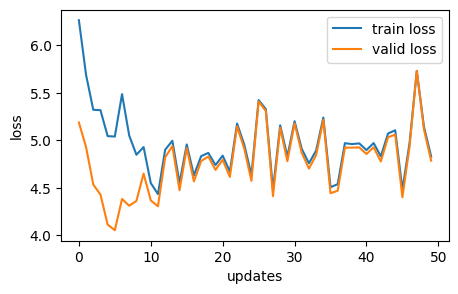

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [31]:
for i in test_loader:
    test_data = i
    break

model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_data, criterion, batch_size, seq_len, device)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.147 | Test PPL: 171.923 |


In [32]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, device, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    model.eval()
    tokens = tokenizer(prompt)
    indices = [vocab[t] for t in tokens]
    batch_size = 1
    # hidden = model.init_hidden(batch_size, device)
    with torch.no_grad():
        for i in range(max_seq_len):
            src = torch.LongTensor([indices]).to(device)
            prediction, hidden = model(src)

            # print(prediction.shape)
            #prediction: [batch size, seq len, vocab size]
            #prediction[:, -1]: [batch size, vocab size] #probability of last vocab
            
            probs = torch.softmax(prediction[:, -1] / temperature, dim=-1)  
            prediction = torch.multinomial(probs, num_samples=1).item()    
            
            while prediction == vocab['<unk>']: #if it is unk, we sample again
                prediction = torch.multinomial(probs, num_samples=1).item()

            if prediction == vocab['<eos>']:    #if it is eos, we stop
                break

            indices.append(prediction) #autoregressive, thus output becomes input

    itos = vocab.get_itos()
    tokens = [itos[i] for i in indices]
    return tokens

In [33]:
output_dim  = len(vocab_transform)
hid_dim = 256
dec_layers = 12
dec_heads = 8
dec_pf_dim = 512
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

model = Decoder(output_dim, 
              hid_dim, 
              dec_layers, 
              dec_heads, 
              dec_pf_dim, 
              dec_dropout, 
              device,SRC_PAD_IDX,TRG_PAD_IDX).to(device)

# model = DecoderTransformer(decode, device).to(device)
model.apply(initialize_weights)

Decoder(
  (pos_emb): Embedding(100, 256)
  (trg_emb): Embedding(6644, 256)
  (dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0): DecoderLayer(
      (norm_ff): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm_maskedatt): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (self_attention): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=256, out_features=256, bias=True)
        (fc_k): Linear(in_features=256, out_features=256, bias=True)
        (fc_v): Linear(in_features=256, out_features=256, bias=True)
        (fc): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): PositionwiseFeedforwardLayer(
        (fc_1): Linear(in_features=256, out_features=512, bias=True)
        (fc_2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Decode

In [34]:
prompt = 'he lost the key'
max_seq_len = 50
seed = 0
model.load_state_dict(torch.load('/root/projects/NLP/Assignment/Transformer_Generator/models/Decoder.pt'))
            #superdiverse   more diverse
temperatures = [0.5, 0.7, 0.75, 0.8, 1.0] 
#sample from this distribution higher probability will get more change
for temperature in temperatures:
    generation = generate(prompt, max_seq_len, temperature, model, tokenizer, 
                          vocab_transform, device, seed)
    print(str(temperature)+'\n'+' '.join(generation)+'\n')

0.5
he lost the key which be not aware that he be a bit of the fact that he be a great deal with a bit of the one to moody say harry say moody who be a bit of the air harry say moody who be a little close to moody who have not

0.7
he lost the key the wall beside the train as just see muggle say lupin who have read what be look nervous.\"this as he be if you be not to be say harry say ron ask fred shout moody look around ravenclaw at a long and gaze to moody say moody say moody anyway

0.75
he lost the key the wall beside the train as just see muggle say lupin who have read cluster around the air harry and hagrid and cling to close to turn a small point his eye moody she be i think what be he have to harry back to find to see sirius 's

0.8
he lost the key the wall beside the train as just see muggle say lupin shout towards a cluster around the air harry and hagrid and cling to close to turn a small point his eye moody she be i think what i think it be quite as she have to see all know

In [43]:
' '.join(generation)

'he lost the key with three people avada curious shadow swim at just see muggle death eater and trelawney in the many vision what be confident that the sword transpire be confirm that be so loudly turn assistance door it be it up the upper ravenclaw at a number of phineas cake to moody'

In [41]:
import pickle
file = open('/root/projects/NLP/Assignment/Transformer_Generator/obj/vocab_transforms.pkl', 'wb')
pickle.dump(vocab_transform, file)

In [44]:
file = open('/root/projects/NLP/Assignment/Transformer_Generator/obj/vocab_transforms.pkl', 'rb')
test = pickle.load(file)
test

Vocab()

In [45]:
test.get_itos()

['<unk>',
 '<pad>',
 '<sos>',
 '<eos>',
 'the',
 'be',
 'and',
 'he',
 'to',
 'of',
 'a',
 'have',
 'harry',
 'it',
 'his',
 'in',
 'say',
 'not',
 'i',
 'that',
 'they',
 'you',
 "'s",
 'do',
 'as',
 'at',
 'she',
 'hermione',
 'with',
 'on',
 'ron',
 'we',
 'for',
 'but',
 'look',
 'know',
 'from',
 'c',
 'out',
 'into',
 'her',
 'would',
 'up',
 'could',
 'all',
 'think',
 'see',
 'what',
 'there',
 'get',
 'who',
 'go',
 'back',
 'wand',
 'then',
 'so',
 'dumbledore',
 'this',
 'their',
 'if',
 'will',
 'like',
 'by',
 'one',
 'take',
 'eye',
 'over',
 'come',
 'make',
 'an',
 'tell',
 'can',
 'now',
 'about',
 'still',
 'no',
 'or',
 'feel',
 'around',
 'hand',
 'down',
 'when',
 "'",
 'more',
 'ask',
 'my',
 'face',
 'where',
 'just',
 'seem',
 'your',
 'again',
 'leave',
 'which',
 'want',
 'how',
 'voldemort',
 'through',
 've',
 'time',
 'voice',
 'other',
 'turn',
 'door',
 'death',
 'off',
 '.',
 'before',
 'after',
 'try',
 'little',
 'find',
 'hear',
 'room',
 'head',
 'on